**MPPI Closed Loop Demo**

# **Installations**

In [ ]:
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout v0

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 690 (delta 200), reused 229 (delta 161), pack-reused 360 (from 1)
Receiving objects: 100% (690/690), 34.63 MiB | 20.01 MiB/s, done.
Resolving deltas: 100% (410/410), done.
/content/balloon-outreach
Branch 'v0_mpc' set up to track remote branch 'v0_mpc' from 'origin'.
Switched to a new branch 'v0_mpc'


In [ ]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.2 MB/s eta 0:00:00
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=5298ef04ea82143b92e1bddd072591d3f3c553a581ad74955df2cd9650a0daa3
  Stored in directory: /root/.cache/pip/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder


In [ ]:
# Download ERA5 data
import gdown
file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
url = f"https://drive.google.com/uc?id={file_id}"
output = "era5_data.nc"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf
From (redirected): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf&confirm=t&uuid=916e246b-bed2-4226-9bf1-5ea2a212dea6
To: /content/balloon-outreach/era5_data.nc
100%|██████████| 1.65G/1.65G [00:17<00:00, 97.0MB/s]


'era5_data.nc'

# **MPPI Optimization Loop**

Below is a review of the optimization loop in the MPPI algorithm:

In [ ]:
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from main_mppi import run_episode
from env.balloon_env import BalloonEnvironment
from agent.mppi_agent import MPPIAgent, MPPIAgentWithCostFunction
import matplotlib.pyplot as plt

initial_lat = 0
initial_lon = 0
initial_alt = 12.0
target_lat = 5
target_lon = 10
target_alt = 12
max_steps = 100
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt)
agent = MPPIAgentWithCostFunction(num_samples=10, acc_bounds=(-0.1,0.1), visualize=False)


horizon = 10
control_sequence = np.zeros(horizon) # our plan of velocities for the balloon


# 1. Sample random control sequences
vertical_velocity = env.balloon.vertical_velocity
base_sequence = control_sequence.copy()
# Add noise to create samples
noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

acc_samples = base_sequence + noise
acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])
accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
vel_samples = vertical_velocity + accumulated_acc_samples

# Clip to action bounds
vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])

# 2. Calculate cost of each sequence
costs = []
for i in range(horizon):
    # Evaluate one sample control sequence
    cost = 0.0
    trajectory = []
    vel_sample = vel_samples[i]
    acc_sample = acc_samples[i]

    cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
    costs.append(cost)

costs = np.array(costs)

# Check for NaN costs and replace with high cost
if np.any(~np.isfinite(costs)):
    print("Warning: NaN costs detected, replacing with high cost")
    costs = np.where(np.isfinite(costs), costs, 1e6)

# 3. Use the costs to calculate weights for each sampled sequence
# Shift costs to prevent numerical issues
costs_shifted = costs - np.min(costs)

# Compute weights using softmax
weights = np.exp(-1 * costs_shifted)
weights = weights / np.sum(weights)

# Check for NaN weights
if np.any(~np.isfinite(weights)):
    print("Warning: NaN weights detected, using uniform weights")
    weights = np.ones_like(weights) / len(weights)

# 4. Compute optimal control sequence by weighted averaging
optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
# Check for NaN in optimal control
if not np.isfinite(optimal_sequence[0]):
    print("Warning: NaN optimal control detected, using zero action")
    optimal_sequence[0] = 0.0

# 5. Update control sequence
control_sequence = optimal_sequence

print(f"Final control sequence: {control_sequence}")

# Plot final velocity
plt.figure(figsize=(12, 5))

for vel_sample in vel_samples:
    plt.plot([i for i in range(horizon)], vel_sample, 'b-', alpha=0.3)
plt.plot([i for i in range(horizon)], control_sequence, 'r-', alpha=1, label='Weighted velocity sequence')
plt.plot(0, control_sequence[0], 'm*', label='Optimal Action')
plt.grid(True)
plt.title(f'Balloon Velocity with MPPI')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Vertical Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.savefig('velocity.png')
plt.show()
plt.close()



Velocity samples are: [[ 0.1         0.04936108  0.13096235  0.23096235  0.28287671  0.38287671
   0.48287671  0.58287671  0.64813347  0.74813347]
 [ 0.00866242  0.00548285 -0.09451715 -0.04873698  0.05126302  0.15126302
   0.23519626  0.22275311  0.23568393  0.13568393]
 [-0.09755557 -0.1189012  -0.21165814 -0.11165814 -0.05275662 -0.11881325
  -0.08837605 -0.05251141 -0.01274845 -0.11274845]
 [-0.03018413  0.01435215 -0.08564785 -0.18564785 -0.20546869 -0.2943221
  -0.27453862 -0.24789636 -0.15161016 -0.11909796]
 [ 0.01350929 -0.01729103  0.03856849  0.02854603 -0.07145397 -0.15029637
  -0.20458121 -0.13778213 -0.03778213 -0.13778213]
 [-0.04826589  0.00201056 -0.01453012 -0.11453012 -0.12460698 -0.22460698
  -0.21951367 -0.25783188 -0.35783188 -0.45783188]
 [-0.08863726 -0.03244976  0.06755024  0.05883166 -0.04116834 -0.0582321
   0.0417679  -0.0582321   0.0417679   0.01695586]
 [-0.1        -0.08630491 -0.00451778  0.04965218  0.00302263 -0.00666023
  -0.10666023 -0.06784807  0.01

# **Trajectory Demo**

These run the MPPI agent for one step and then visualize the sampled & final trajectories.

Basic MPPI with Basic WindField:

MPPI evaluation time took: 2.309619903564453


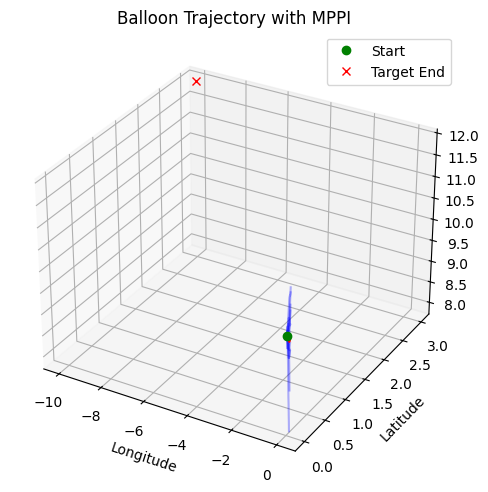

Step 0: lat: 0.00, lon: 0.00, alt: 10.00
Average time to get one action: 2.8664679527282715
Average time to take one step: 0.011409282684326172
Average time to get one action: 2.8664679527282715


In [ ]:
# Demo without windfield
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from main_mppi import run_episode
from env.balloon_env import BalloonEnvironment
from agent.mppi_agent import MPPIAgent
import matplotlib.pyplot as plt

initial_lat = 0
initial_lon = 0
initial_alt = 12.0
target_lat = 3
target_lon = -10
target_alt = 12
noise_std = 1
horizon=50
num_samples=10
num_iterations=1
vel_bounds = (-1.0, 1.0)
time_step = 120
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt, dt=time_step)
agent = MPPIAgent(horizon=horizon, num_samples=num_samples,num_iterations=num_iterations, vel_bounds=vel_bounds,visualize=True)

reward = run_episode(env, agent, max_steps=1)


MPPI with Cost and ERA WindField:

MPPI evaluation time took: 1.7039244174957275


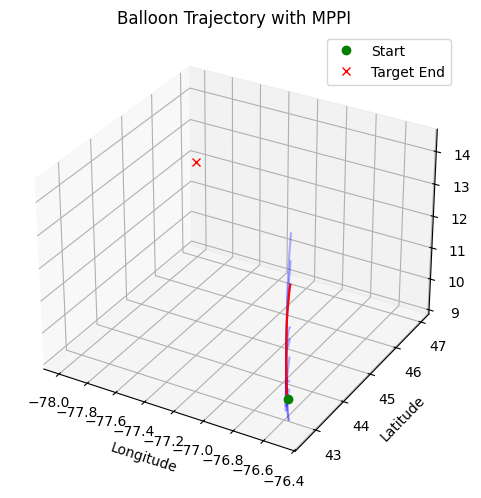

Step 0: lat: 42.60, lon: -76.50, alt: 9.99
Average time to get one action: 2.1507439613342285
Average time to take one step: 0.009914636611938477
Average time to get one action: 2.1507439613342285


In [ ]:
# Demo with windfield and more complex agent
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from main_mppi import run_episode
from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt

 #This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day
noise_std = 1
horizon=50
num_samples=10
num_iterations=1
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, dt=time_step, viz=False)
agent = MPPIAgentWithCostFunction(target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)


# **Changing Hyperparameters**

With MPPI you can change:

- temperature ($λ$) - sharpness of the weighting
- number of samples ($n$) - variety of trajectories
- standard deviation ($σ$) - determines randomness
- horizon length ($h$) - length of plan to generate
- number of iterations ($i$) - how many times to optimize a plan
- acceleration bounds ($(a_1, a_2)$)

*(We are not changing velocity bounds as that is part of the balloon dynamics, not just the trajectory)*

For each hyperparameter, you can modify the values (and even initial and target points) and see how the sampled and final trajectories might change.

In [ ]:
# Rerun this cell between each hyperparameter demo to reset the values
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds - this is technically for the environment, but you can also explore changing this
max_steps = int(1440/(time_step/60)) #1 day
acc_bounds = (-0.1,0.1)
noise_std = 1
horizon=50
num_samples=10
num_iterations=1
temperature=10

*Temperature:*

MPPI evaluation time took: 1.7791969776153564


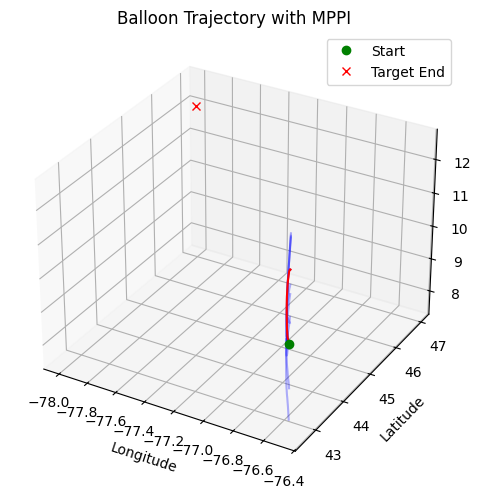

Step 0: lat: 42.60, lon: -76.50, alt: 10.01
Average time to get one action: 2.2602572441101074
Average time to take one step: 0.009971380233764648
Average time to get one action: 2.2602572441101074


In [ ]:
env.reset()
agent1 = MPPIAgentWithCostFunction(temperature = 0.01, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

MPPI evaluation time took: 2.2165486812591553


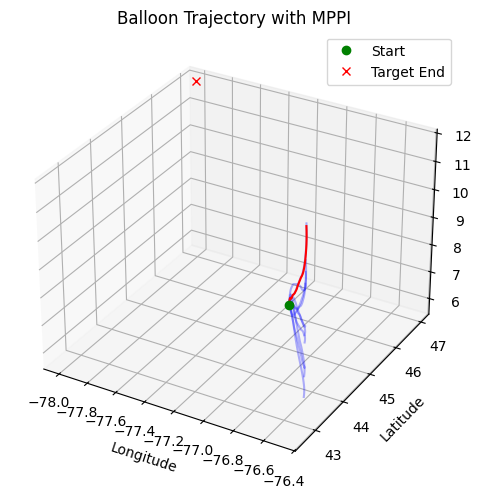

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Average time to get one action: 2.823992967605591
Average time to take one step: 0.016439437866210938
Average time to get one action: 2.823992967605591


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(temperature = 100, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Number of samples:*

MPPI evaluation time took: 1.0891001224517822


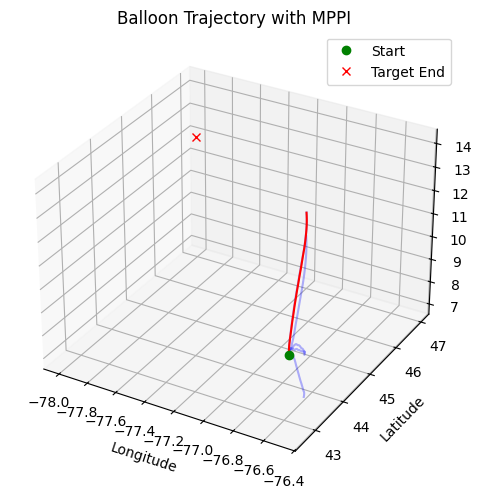

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Average time to get one action: 1.7179558277130127
Average time to take one step: 0.012934446334838867
Average time to get one action: 1.7179558277130127


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(num_samples = 5, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

MPPI evaluation time took: 12.385627269744873


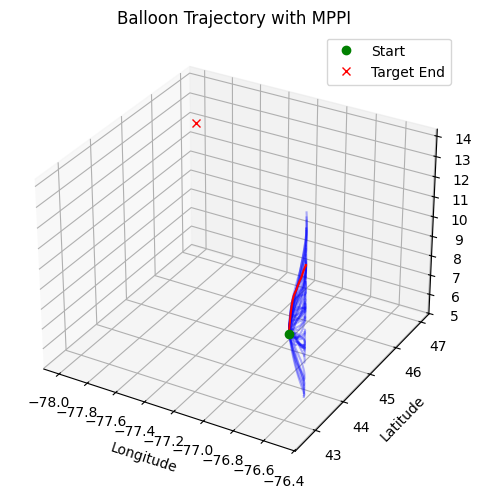

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Average time to get one action: 13.169584274291992
Average time to take one step: 0.012869119644165039
Average time to get one action: 13.169584274291992


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(num_samples = 50, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Standard deviation* - this has less of an effect in our environment unless acceleration and velocity are clipped to different ranges. For example, even if std_dev=5, velocity is set to be between -1 to 1 so the samples would mostly be -1 or 1.

MPPI evaluation time took: 2.216409683227539


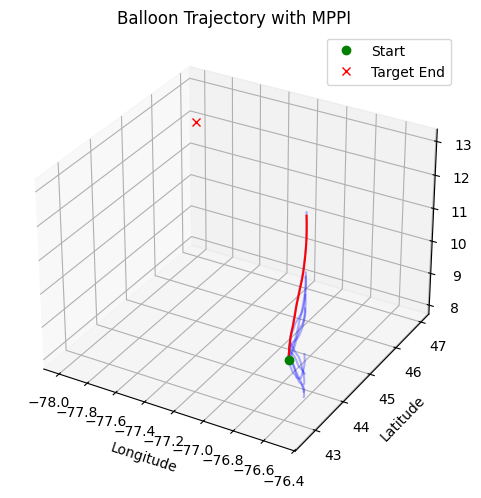

Step 0: lat: 42.61, lon: -76.50, alt: 10.00
Average time to get one action: 2.8585269451141357
Average time to take one step: 0.012964010238647461
Average time to get one action: 2.8585269451141357


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(noise_std=0.1, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

MPPI evaluation time took: 2.5563066005706787


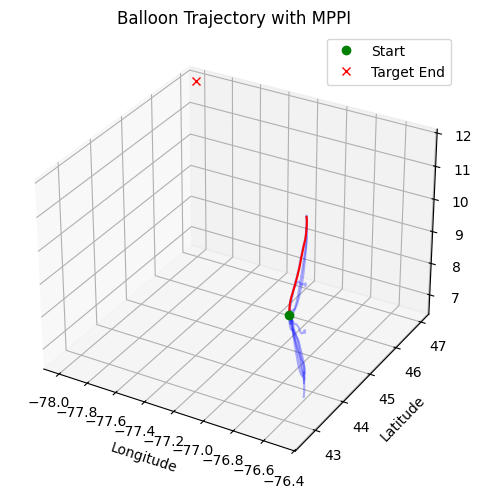

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Average time to get one action: 3.488844871520996
Average time to take one step: 0.016065120697021484
Average time to get one action: 3.488844871520996


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(noise_std=2, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Horizon length* - having too large of a horizon can compound mistakes in trajectories and increase computation time, but having too small of a horizon doesn't account for long term effects.

MPPI evaluation time took: 0.43130064010620117


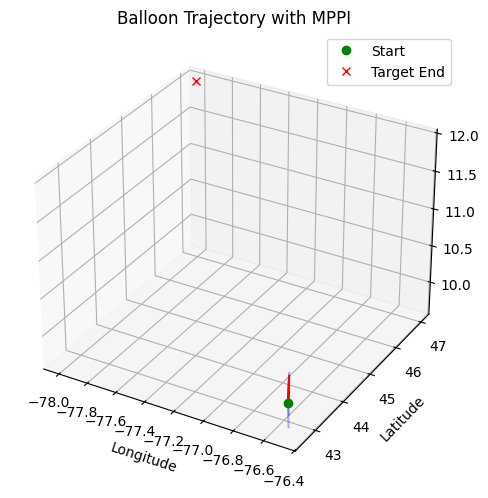

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Average time to get one action: 0.98097825050354
Average time to take one step: 0.06200671195983887
Average time to get one action: 0.98097825050354


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(horizon=10, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

MPPI evaluation time took: 4.418838024139404


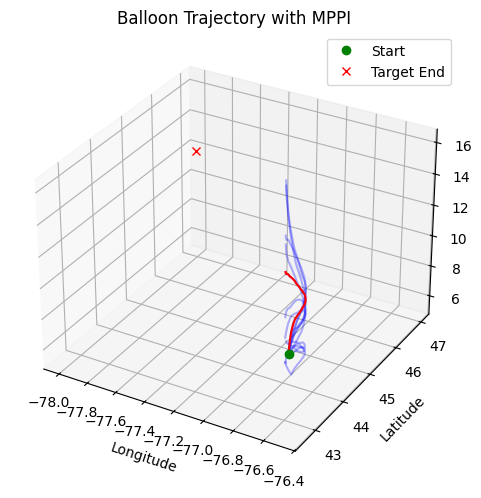

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Average time to get one action: 5.312130928039551
Average time to take one step: 0.02316904067993164
Average time to get one action: 5.312130928039551


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(horizon=100, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Number of iterations*

MPPI evaluation time took: 2.4631636142730713


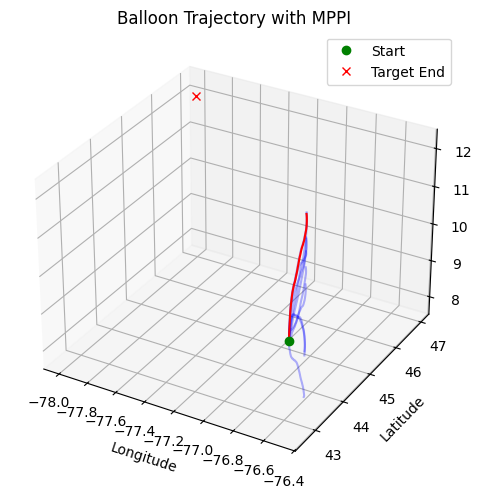

Step 0: lat: 42.61, lon: -76.50, alt: 10.01
Average time to get one action: 3.1169610023498535
Average time to take one step: 0.018939733505249023
Average time to get one action: 3.1169610023498535


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(num_iterations=1, horizon=horizon, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

MPPI evaluation time took: 2.284719467163086


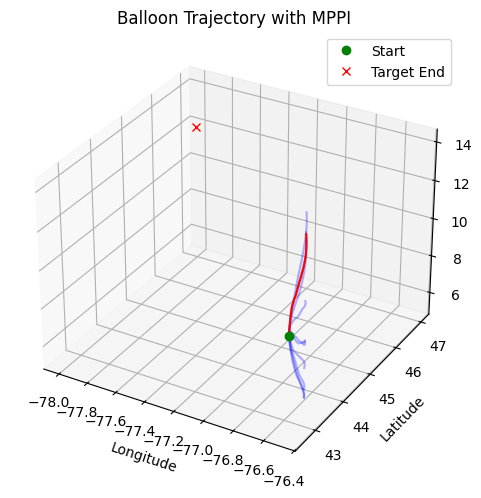

Step 0: lat: 42.61, lon: -76.50, alt: 9.99
Average time to get one action: 2.9501829147338867
Average time to take one step: 0.013041496276855469
Average time to get one action: 2.9501829147338867


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(num_iterations=30, horizon=horizon, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Acceleration bounds* - lower bounds allows for smoother control, but slower movement

MPPI evaluation time took: 2.2083258628845215


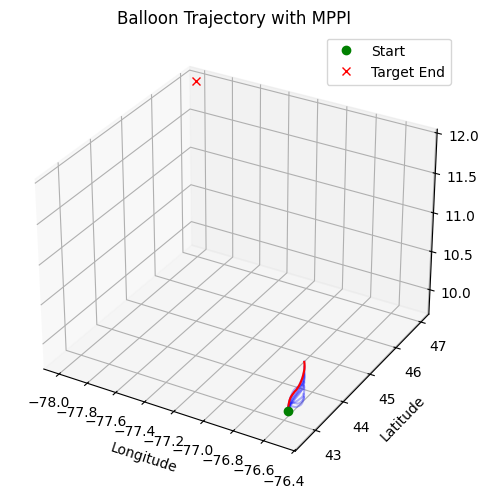

Step 0: lat: 42.61, lon: -76.50, alt: 10.00
Average time to get one action: 2.90916109085083
Average time to take one step: 0.017149686813354492
Average time to get one action: 2.90916109085083


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(acc_bounds=(-0.01, 0.01), temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

MPPI evaluation time took: 2.941236972808838


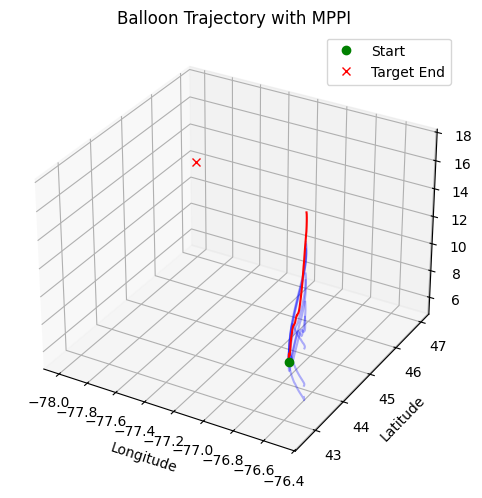

Step 0: lat: 42.61, lon: -76.50, alt: 10.00
Average time to get one action: 3.547027349472046
Average time to take one step: 0.01861429214477539
Average time to get one action: 3.547027349472046


In [ ]:
env.reset()
agent = MPPIAgentWithCostFunction(acc_bounds=(-1, 1), temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Environment timestep* - larger times run faster but can impact performance

In [ ]:
env = BalloonERAEnvironment(dt=60,ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, viz=False)
agent = MPPIAgentWithCostFunction(acc_bounds=acc_bounds, temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

In [ ]:
env = BalloonERAEnvironment(dt=600,ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, viz=False)
agent = MPPIAgentWithCostFunction(acc_bounds=acc_bounds, temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)